# P2: Investigate a Dataset
## 1. Overview of the project

The main goal of this project is to explore which factors could be associated with survivial rates for the Titanic disaster. I chose to explore correlation between survival rate and each of five factors: passenger class, sex, age category (child or adult), parenting status within grownups (parent or not parent) and marriage status of woman (miss or mrs). This factors was chosen based on the following intuitions:
* Richer people (from higher passenger class) got more chances to survive
* "Women and children first"
* Saved children needed to be accompanied by parent, so adults with children might have a better chance to survived than not parents.
* Married women would have help of their husbands, while unmarried women have no one to care about them

Further analysis checks those intutions as well as explores relations between multiple factors.

## 2. Data preparation
### 2.1 Establishing plan of data preparations

In [35]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Load data form CSV
titanic_data = pd.read_csv('titanic-data.csv', header=0)

Let's take a look at our data:

In [36]:

titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In order to clean data for further analysis, we need to identify value types and missing values:

In [37]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


As our analysis is going to be concentrated on such factors as Passenger Class, Sex, Age and Number of Parents/Children Aboard, we will perform following operations:
* Creating label columns for categorical features
* Fill missing values in Age column
* Create two new features: AgeCategory, ParentingStatus, Status
* Creating numerical analogs for categorical features

### 2.2 Creating labels columns for categorical features

In [38]:
titanic_data['Survival'] = titanic_data['Survived'].map({0: 'Died', 1: 'Survived'}).astype('category')
titanic_data['Class'] = titanic_data['Pclass'].map({1: 'First Class', 2: 'Second Class', 3: 'Third Class'}).astype('category')
titanic_data['Port'] = titanic_data['Embarked'].map({'C' : 'Cherbourg', 'Q' : 'Queenstown', 'S' : 'Southampton'}).astype('category')

### 2.3. Filling missing values

At first, we'll look at ages distribution.

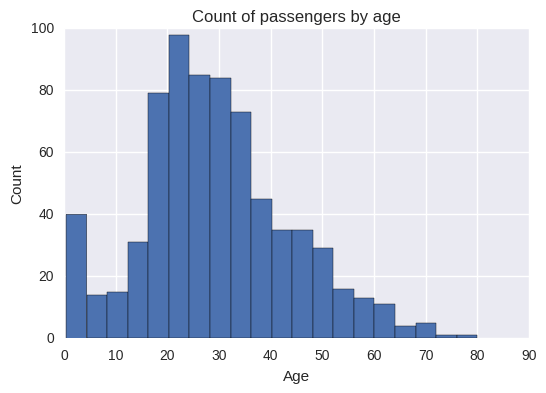

In [39]:
plt.hist(titanic_data['Age'].dropna(), bins=20)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Count of passengers by age")

Looks like Ages distribution is positevely skewed. So a median would be more reasonable guess for missing values, than a mean. For even better use, we could use the age that was typical for each combination of passenger class, sex and port of embarkation. Let's see a table with each of this medians:

In [40]:
median_ages = titanic_data[['Class', 'Sex', 'Port', 'Age']].groupby(['Class', 'Sex', 'Port']).median()
median_ages

Age
Class        Sex    Port              
First Class  female Cherbourg    37.00
                    Queenstown   33.00
                    Southampton  33.00
             male   Cherbourg    36.50
                    Queenstown   44.00
                    Southampton  42.00
Second Class female Cherbourg    22.00
                    Queenstown   30.00
                    Southampton  29.00
             male   Cherbourg    29.50
                    Queenstown   57.00
                    Southampton  30.00
Third Class  female Cherbourg    14.25
                    Queenstown   20.00
                    Southampton  23.00
             male   Cherbourg    26.00
                    Queenstown   27.00
                    Southampton  25.00

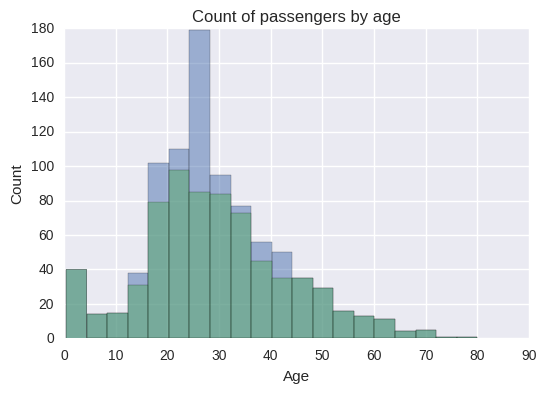

In [41]:
#Filling missing values with corresponding medians from table
titanic_data['FilledAge'] = titanic_data['Age']
for sex in ['male', 'female']:
    for passenger_class in ['First Class', 'Second Class', 'Third Class']:
        for port in ['Cherbourg', 'Queenstown', 'Southampton']:
            titanic_data.loc[(titanic_data.Age.isnull()) & 
                             (titanic_data.Sex == sex) & 
                             (titanic_data.Class == passenger_class) & 
                             (titanic_data.Port == port), 'FilledAge'] \
            = median_ages.loc[passenger_class, sex, port][0]
            
#Comparison of distributions
plt.hist(titanic_data['FilledAge'], bins=20, alpha=0.5, label="FilledAges")
plt.hist(titanic_data['Age'].dropna(), bins=20, alpha=0.5, label="original Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Count of passengers by age")

We can see, that filling missing age values by medians corresponding particular combination of class, sex and embarkation port gives us a good fit to the original ages distributions. But we should remember that this opeartion gives us a downplayed variance, which will lead to the impaired in some degree results in computations of any correlation with this feature.

### 2.4. Creation of new features


In [42]:
titanic_data['AgeCategory'] = 'Adult'
titanic_data.loc[(titanic_data['FilledAge'] <= 18), 'AgeCategory'] = 'Child'
titanic_data['AgeCategory'].value_counts()

Adult    745
Child    146
Name: AgeCategory, dtype: int64

In [43]:
titanic_data['ParentingStatus'] = 'NotParent'
titanic_data.loc[(titanic_data['AgeCategory'] == 'Adult') & 
                 (titanic_data['Parch'] > 0), 'ParentingStatus'] = 'Parent'
titanic_data['ParentingStatus'].value_counts()

NotParent    770
Parent       121
Name: ParentingStatus, dtype: int64

In [44]:
def define_status(s):
    raw_name = s['Name']
    status_beginning = raw_name.find(',') + 2
    status_ending = raw_name.find('.')
    status = raw_name[status_beginning:status_ending]
    return status

titanic_data['Status'] = titanic_data.apply(define_status, axis=1)
titanic_data['Status'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: Status, dtype: int64

### 2.5. Creating numerical analogs of categorical features

In [45]:
titanic_data['NumSex'] = titanic_data['Sex'].map({'male': 0, 'female': 1})
titanic_data['NumAgeCategory'] = titanic_data['AgeCategory'].map({'Child': 1, 'Adult': 2})
titanic_data['NumParentingStatus'] = titanic_data['ParentingStatus'].map({'NotParent': 1, 'Parent': 2})
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
PassengerId           891 non-null int64
Survived              891 non-null int64
Pclass                891 non-null int64
Name                  891 non-null object
Sex                   891 non-null object
Age                   714 non-null float64
SibSp                 891 non-null int64
Parch                 891 non-null int64
Ticket                891 non-null object
Fare                  891 non-null float64
Cabin                 204 non-null object
Embarked              889 non-null object
Survival              891 non-null category
Class                 891 non-null category
Port                  889 non-null category
FilledAge             891 non-null float64
AgeCategory           891 non-null object
ParentingStatus       891 non-null object
Status                891 non-null object
NumSex                891 non-null int64
NumAgeCategory        891 non-null int64
NumParentin

## 3. Data exploration
### 3.1 Survival rate in different passanger classes
It should be noted that 3rd class contains more than twice the amount of data points, than two others classes. Nonetheless, all classes have enough values for the further statistical method.

In [46]:
titanic_data['Class'].value_counts()

Third Class     491
First Class     216
Second Class    184
Name: Class, dtype: int64

Now, let's visualize the survival rate by passanger class

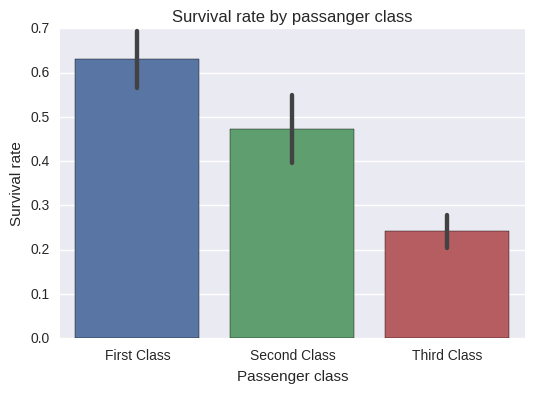

In [47]:
ax = sns.barplot(x="Class", y="Survived", data=titanic_data)
ax.set(title='Survival rate by passanger class', xlabel='Passenger class', ylabel='Survival rate')
ax

Let's perform a Chi-Squared test for independence with a confidence level of $\alpha = 0.05$ to reject $H_0$. 

$H_0:$ $Survival$ $rate$ $and$ $Passenger$ $class$ $are$ $independent$

$H_A:$ $Survival$ $rate$ $and$ $Passenger$ $class$ $are$ $dependent$

In [48]:
observed_class = pd.crosstab(titanic_data['Survived'], titanic_data['Pclass'])
chi_squared, p_values, _, _ = stats.chi2_contingency(observed=observed_class)
(chi_squared, p_values)

(102.88898875696056, 4.5492517112987927e-23)

The test shows a Chi-Squared statistic of 102.89 with a p-value way to less than 0.05, so the null hypothesis could be rejected.

### 3.2 Survival rate by sex

It should be noted that male sex contains more data points, than female sex. Nonetheless, both sexes have enough values for the further statistical method.

In [49]:
titanic_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Now let's visualize survival rate by sex

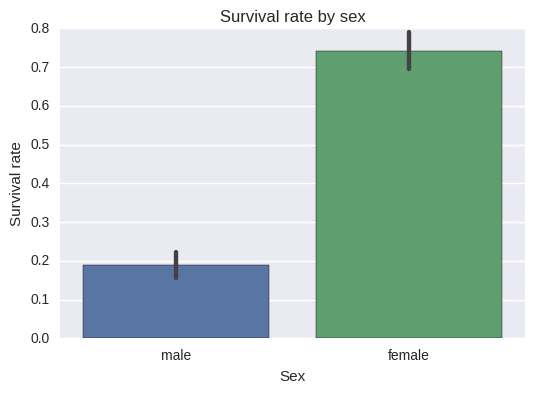

In [50]:
ax = sns.barplot(x="Sex", y="Survived", data=titanic_data)
ax.set(title='Survival rate by sex', xlabel='Sex', ylabel='Survival rate')
ax

Let's perform a Chi-Squared test for independence with a confidence level of $\alpha = 0.05$ to reject $H_0$. 

$H_0:$ $Survival$ $rate$ $and$ $Sex$ $are$ $independent$

$H_A:$ $Survival$ $rate$ $and$ $Sex$ $are$ $dependent$

In [51]:
observed_sex = pd.crosstab(titanic_data['Survived'], titanic_data['NumSex'])
chi_squared, p_values, _, _ = stats.chi2_contingency(observed=observed_sex)
(chi_squared, p_values)

(260.71702016732104, 1.1973570627755645e-58)

The test shows a Chi-Squared statistic of 260.72 with a p-value way to less than 0.05, so the null hypothesis could be rejected.

### 3.3 Survival rate by Age Category

It should be noted that GrownUp age category contains much more data points, than Child age category. Nonetheless, both age categories have enough values for the further statistical method.

In [52]:
titanic_data['AgeCategory'].value_counts()

Adult    745
Child    146
Name: AgeCategory, dtype: int64

Now let's visualize survival rate by Age Category

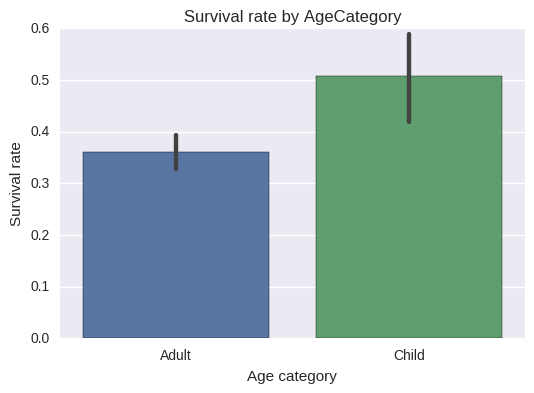

In [53]:
ax = sns.barplot(x="AgeCategory", y="Survived", data=titanic_data)
ax.set(title='Survival rate by AgeCategory', xlabel='Age category', ylabel='Survival rate')
ax

Let's perform a Chi-Squared test for independence with a confidence level of $\alpha = 0.05$ to reject $H_0$. 

$H_0:$ $Survival$ $rate$ $and$ $AgeCategory$ $are$ $independent$

$H_A:$ $Survival$ $rate$ $and$ $AgeCategory$ $are$ $dependent$

In [54]:
observed_age_category = pd.crosstab(titanic_data['Survived'], titanic_data['NumAgeCategory'])
chi_squared, p_values, _, _ = stats.chi2_contingency(observed=observed_age_category)
(chi_squared, p_values)

(10.558297906673593, 0.001156676565384819)

The test shows a Chi-Squared statistic of 10.56 with a p-value less than 0.05, so the null hypothesis could be rejected.

### 3.4 Survival rate by Parenting Status within grownups.

It should be noted that there is much more not parents within grownups, than parents. Nonetheless, there is enough values for each of Parenting status within grownups for the further statistical method.

In [55]:
titanic_data_adult = titanic_data[titanic_data['AgeCategory'] == 'Adult']
titanic_data_adult['ParentingStatus'].value_counts()

NotParent    624
Parent       121
Name: ParentingStatus, dtype: int64

Let's visualize survival rate py parenting status within adults

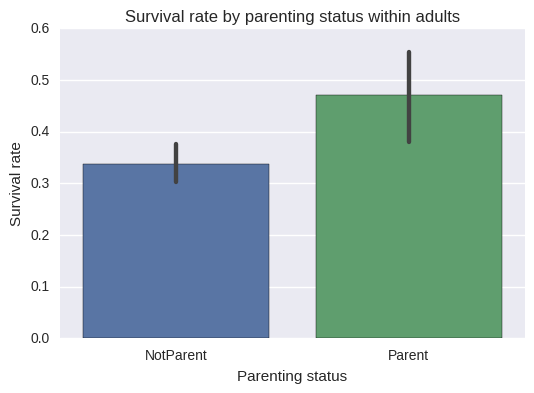

In [56]:
ax = sns.barplot(x="ParentingStatus", y="Survived", data=titanic_data_adult)
ax.set(title='Survival rate by parenting status within adults', xlabel='Parenting status', ylabel='Survival rate')
ax

Let's perform a Chi-Squared test for independence with a confidence level of $\alpha = 0.05$ to reject $H_0$. 

$H_0:$ $Survival$ $rate$ $and$ $ParentingStatus$ $are$ $independent$

$H_A:$ $Survival$ $rate$ $and$ $ParentingStatus$ $are$ $dependent$

In [57]:
observed_parenting_status = pd.crosstab(titanic_data_adult['Survived'], titanic_data_adult['NumParentingStatus'])
chi_squared, p_values, _, _ = stats.chi2_contingency(observed=observed_parenting_status)
(chi_squared, p_values)

(7.2092804505884178, 0.0072527565411012115)

The test shows a Chi-Squared statistic of 7.21 with a p-value less than 0.05, so the null hypothesis could be rejected.

### 3.5 Survival rate by marriage status for women

Both marriage status 'Miss' and 'Mrs' have about the same data points and there is enough values for each of this marriage statuses for the further statistical method.

In [58]:
titanic_data_miss_or_mrs = titanic_data[(titanic_data['Status'] == 'Mrs') | (titanic_data['Status'] == 'Miss')]
titanic_data_miss_or_mrs['Status'].value_counts()

Miss    182
Mrs     125
Name: Status, dtype: int64

Let's visualize survival rate by marriage status for women.

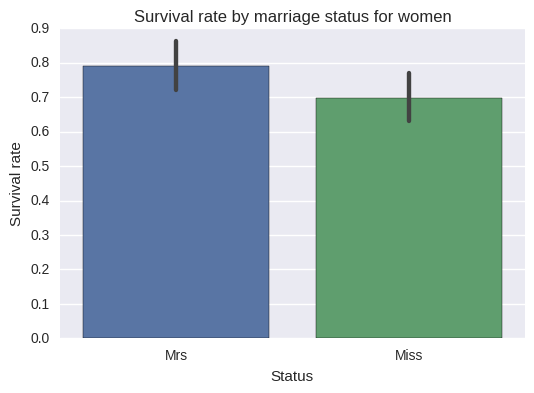

In [59]:

ax = sns.barplot(x="Status", y="Survived", data=titanic_data_miss_or_mrs)
ax.set(title='Survival rate by marriage status for women', xlabel='Status', ylabel='Survival rate')
ax

Let's perform a Chi-Squared test for independence with a confidence level of $\alpha = 0.05$ to reject $H_0$. 

$H_0:$ $Survival$ $rate$ $and$ $Status$ $for$ $women$ $are$ $independent$

$H_A:$ $Survival$ $rate$ $and$ $Status$ $for$ $women$ $are$ $dependent$

In [60]:
observed_status = pd.crosstab(titanic_data_miss_or_mrs['Survived'], titanic_data_miss_or_mrs['Status'])
chi_squared, p_values, _, _ = stats.chi2_contingency(observed=observed_status)
(chi_squared, p_values)

(2.9177723433018414, 0.087608734831152557)

The test shows a Chi-Squared statistic of 2.92 with a p-value more than 0.05, so the null hypothesis couldn't be rejected.

### 3.6 Survival rate by class and sex

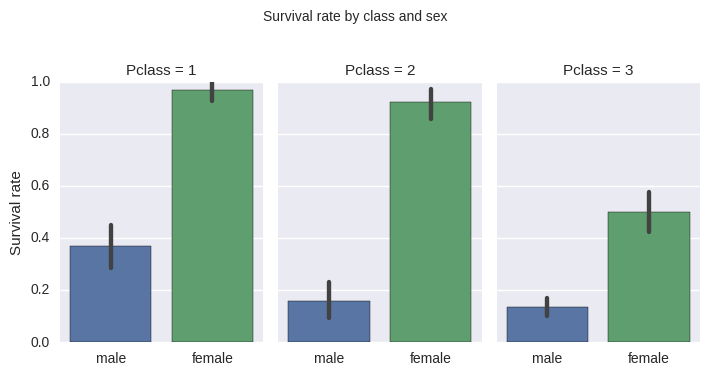

In [61]:
g = sns.factorplot(x="Sex", y="Survived", col="Pclass", data=titanic_data, kind="bar", aspect=.6)
g.set_axis_labels("", "Survival rate")
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Survival rate by class and sex')

Here we can see, that survival rate is lower in a lower passenger class amongs both males and females, but in the same time survival rate amongst females even from third class is higher, than amongst males from first class.

### 3.7 Survival rate by class and age category

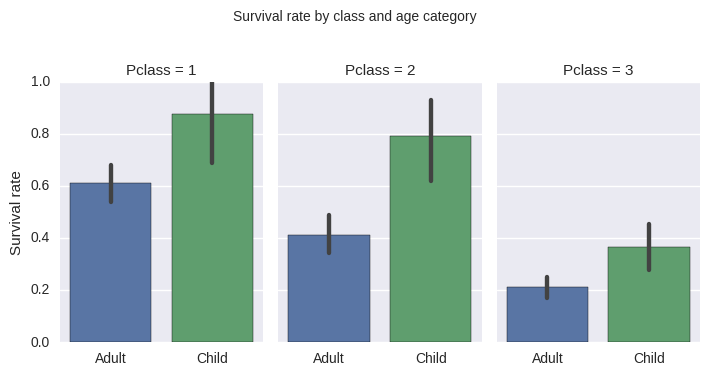

In [62]:
g = sns.factorplot(x="AgeCategory", y="Survived", col="Pclass", data=titanic_data, kind="bar", aspect=.6)
g.set_axis_labels("", "Survival rate")
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Survival rate by class and age category')

Within each passanger class survival rate for children is higher than for adults. But we can also see that children from 3rd class have lower survival rate, than adults in both first and second class. I guess, high survival rates of adult women influnced overall adult's survival rate a lot. 

### 3.8 Age distribution 

Let's see age distribution for different groups of passengers.

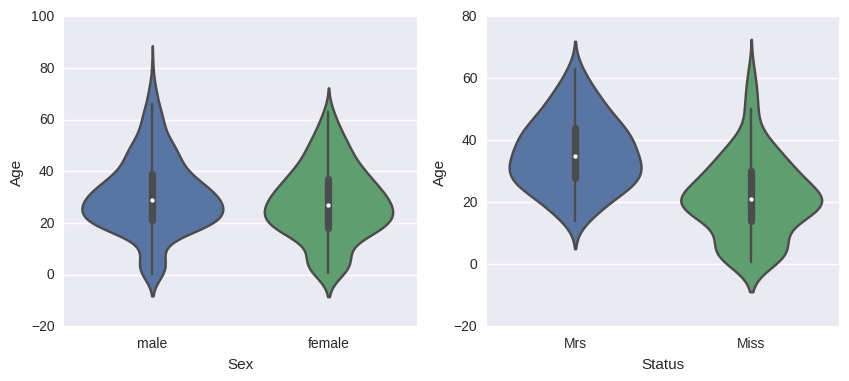

In [63]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
sns.violinplot(data=titanic_data, x='Sex', y='Age', ax=ax1)
sns.violinplot(data=titanic_data_miss_or_mrs, x='Status', y='Age', ax=ax2)

On a left plot we can see that in general female passangers are younger, than males. Also age distribution for females is kind of multimodal: there is a small second peak around 2 years. As could be expected, married woman are seems to be older in general than single ones. There is also second peak around 2 years for miss, which is not surprising. We would expect that female children are not married yet.

## 4. Conclusion

Findings:

From the analysis performed in the Data Exploartion section it was found that class, sex, age category and parenting status were correlated with survival rate, while marriage status of woman was not. Marriage status failed to pass an independent sample t-test at a criterion of $\alpha = 0.05$ so it failed to show a statistically significant difference between the groups means. 
While result support most of the intuitons mentioned in the beginning of project, they only show correlations and can't be used to infer any causations. 

Limitations:

It worths to mentions, that before the analysis we filled missing values of Age using the median values matching sex, class and emabrking port. This caused the the correlation between age category (based on age) and surviving to be understated. 
Also it's important to remember, that this project was focused on single variable associations. Meanwhile some part of variable correlation might be explained by another related variable. For example, some of the correlation between parenting status and survival rate can be explained by the higher rate of females amongst parents, as shown below. 

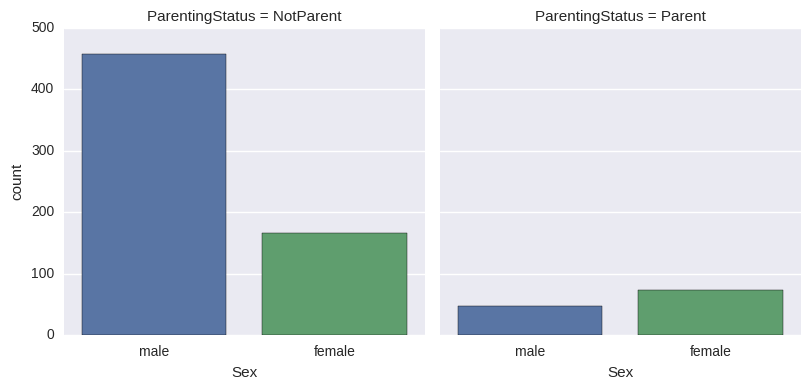

In [64]:
 g = sns.factorplot("Sex", col="ParentingStatus", data=titanic_data_adult, kind="count")

Also important to keep in mind, that there could be other variables, affecting correlation, which are not even presented in this dataset.